# Linear Tree

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from joblib import dump
import numpy as np

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression

In [4]:
train =  pd.read_parquet('../../../data/model_input/train_sets/house_prices.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/house_prices.parquet')

In [5]:
y_train = train.SalePrice
X_train = train.drop(columns=['SalePrice'])

In [6]:
y_validation = validation.SalePrice
X_validation = validation.drop(columns=['SalePrice'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [9]:
y_train_scaled = y_train/1000
y_validation_scaled = y_validation/1000

In [21]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
base_est = [LinearRegression(), Ridge(), Lasso(max_iter=3000), ElasticNet(l1_ratio=0.25), ElasticNet(), ElasticNet(l1_ratio=0.75)]

In [56]:
models_list = []
names_list = []

for i in max_depth:
    for est in base_est:
        models_list.append(LinearTreeRegressor(base_estimator=est, max_depth=i))
    names_list.extend(['LT_'+str(i), 'LT_'+str(i)+'_l2', 'LT_'+str(i)+'_l1', 'LT_'+str(i)+'_en_0.25', 'LT_'+str(i)+'_en_0.5', 'LT_'+str(i)+'_en_0.75'])

In [59]:
metrics = regression(models_list, names_list, '../../../data/metrics/house_prices/linear_tree.csv', X_train_scaled, y_train_scaled, X_validation_scaled, y_validation_scaled, metrics={})
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LT_1,64.530630,11.927447,117173.492031,982285.368455
LT_1_l2,7.263908,12.538467,42.657216,240.210775
LT_1_l1,9.007301,16.828043,30.659819,82.194803
LT_1_en_0.25,7.968351,19.515101,38.097909,95.222712
LT_1_en_0.5,7.985888,18.864904,37.548881,99.040938
...,...,...,...,...
LT_15_l2,11.148134,4.029709,48.076615,1093.054422
LT_15_l1,13.330603,11.626027,33.000062,183.846438
LT_15_en_0.25,11.353105,15.189118,38.063416,150.596615
LT_15_en_0.5,11.657796,14.460569,40.021982,176.766306


In [67]:
metrics.sort_values(by='Validation_RMSE')

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LT_2_l1,11.863935,14.845583,29.900953,101.413127
LT_1_l1,9.007301,16.828043,30.659819,82.194803
LT_3_l1,13.165010,12.961198,31.954529,146.539933
LT_4_l1,13.705558,11.962754,32.898244,175.005615
LT_12_l1,13.609125,11.626027,33.000062,183.846438
...,...,...,...,...
LT_12,92.556361,3.430035,12752.879286,371700.217280
LT_4,89.019468,3.599476,12754.342014,354238.835650
LT_3,92.221965,5.224740,27833.378927,532622.708655
LT_2,81.991192,8.763274,31357.377706,357727.204906


We are going to choose **LT_2_l1**.

In [70]:
test =  pd.read_parquet('../../../data/model_input/test_sets/house_prices.parquet')

In [71]:
y_test = test.SalePrice
X_test = test.drop(columns=['SalePrice'])

In [72]:
retrain = pd.concat([train, validation])

In [73]:
y_retrain = retrain.SalePrice
X_retrain = retrain.drop(columns=['SalePrice'])

In [74]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [75]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [76]:
y_retrain_scaled = y_retrain/1000
y_test_scaled = y_test/1000

In [79]:
model = LinearTreeRegressor(base_estimator=Lasso(max_iter=3000), max_depth=2).fit(X_retrain_scaled, y_retrain_scaled)

In [80]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test_scaled, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 25.8673


In [82]:
dump(model, 'best_linear_tree.joblib')

['best_linear_tree.joblib']

In [83]:
with open('../../../data/metrics/house_prices/final_RMSE.txt', 'a') as f:
    f.write('\nLT, '+ str(rmse))

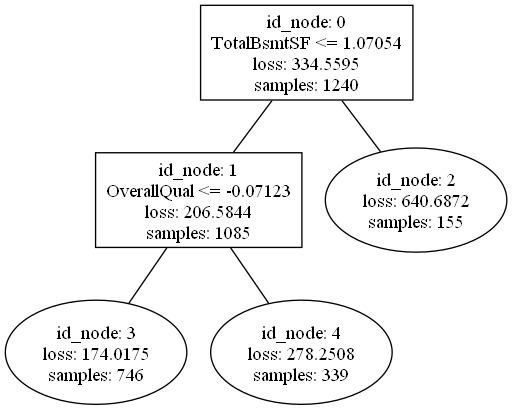

In [84]:
model.plot_model(feature_names=X_retrain.columns)

We are going to plot each model separately due to the amount of features we have

In [113]:
leaves = model.summary(only_leaves=True)

In [127]:
top_threshold3 = 3
top_coefficients3 = [coef for coef in leaves[3]['models'].coef_.ravel() if abs(coef) > top_threshold3]
top_features3 = [name for name, coef in zip(X_retrain.columns, leaves[3]['models'].coef_.ravel()) if abs(coef) > top_threshold3]

In [128]:
labels3 = [' ' if feature not in top_features3 else feature for feature in X_retrain.columns]

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16820/1811725864.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90, ha='right')


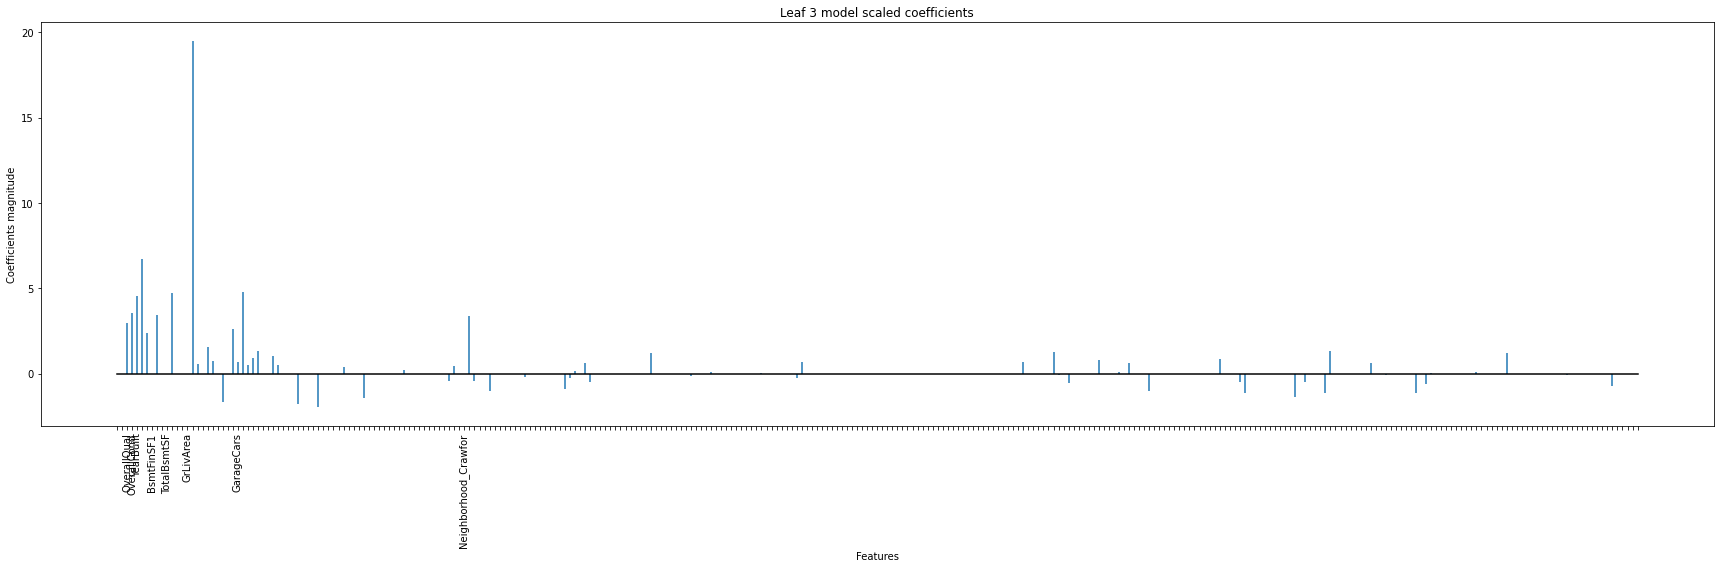

In [129]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, leaves[3]['models'].coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Leaf 3 model scaled coefficients')
ax.set_xticklabels(labels3, rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [139]:
top_threshold4 = 3
top_coefficients4 = [coef for coef in leaves[3]['models'].coef_.ravel() if abs(coef) > top_threshold4]
top_features4 = [name for name, coef in zip(X_retrain.columns, leaves[4]['models'].coef_.ravel()) if abs(coef) > top_threshold4]

In [140]:
labels4 = [' ' if feature not in top_features4 else feature for feature in X_retrain.columns]

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16820/2312693884.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels4, rotation=90, ha='right')


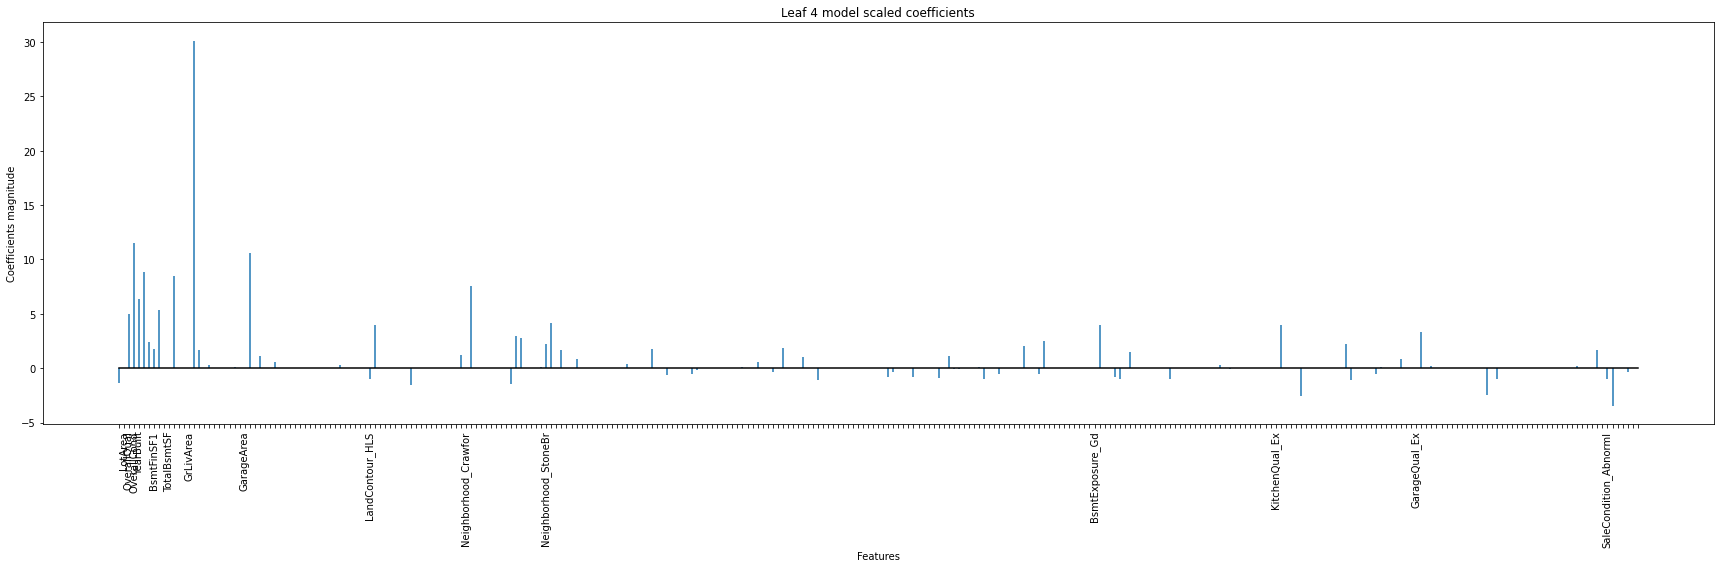

In [141]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, leaves[4]['models'].coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Leaf 4 model scaled coefficients')
ax.set_xticklabels(labels4, rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [142]:
top_threshold2 = 10
top_coefficients2 = [coef for coef in leaves[3]['models'].coef_.ravel() if abs(coef) > top_threshold2]
top_features2 = [name for name, coef in zip(X_retrain.columns, leaves[2]['models'].coef_.ravel()) if abs(coef) > top_threshold2]

In [143]:
labels2 = [' ' if feature not in top_features2 else feature for feature in X_retrain.columns]

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16820/2510691937.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels2, rotation=90, ha='right')


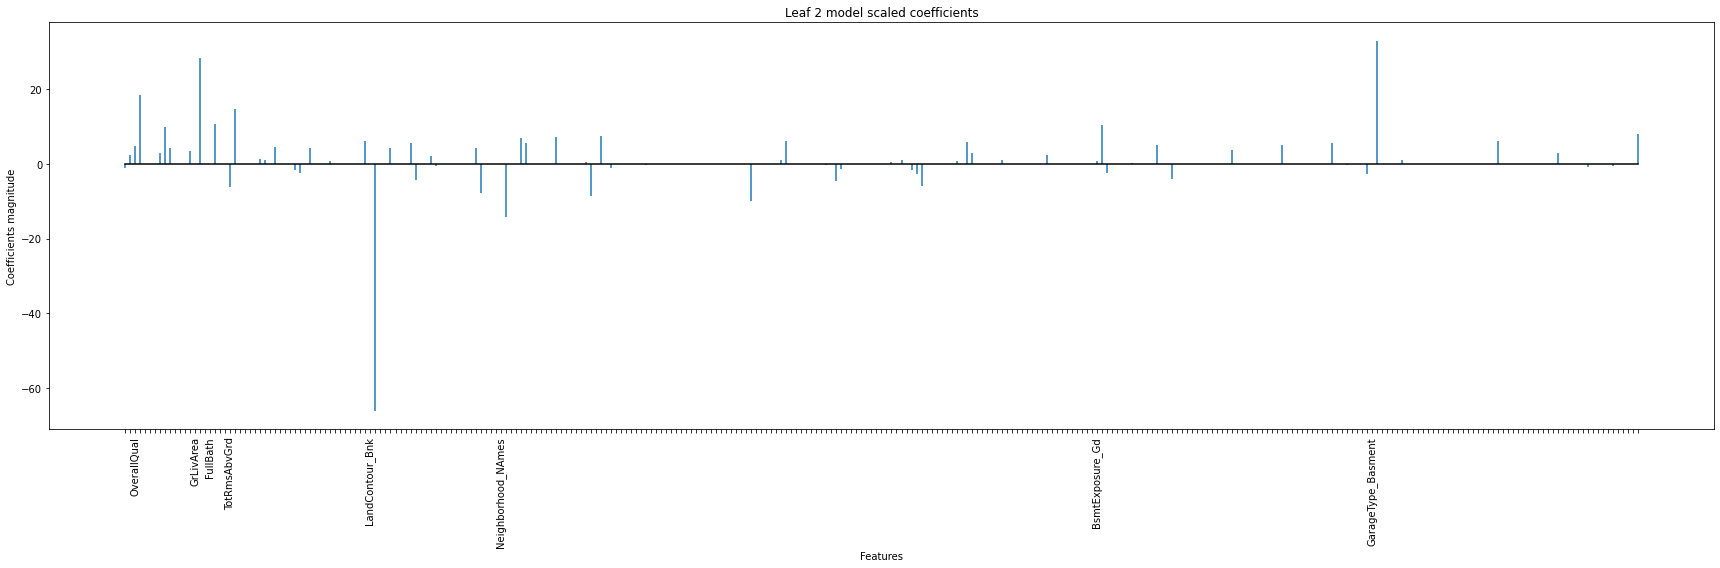

In [144]:
fig, ax = plt.subplots(figsize=(24, 8))
ax.stem(X_retrain.columns, leaves[2]['models'].coef_.ravel(), markerfmt=' ', basefmt='k-')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients magnitude')
ax.set_title('Leaf 2 model scaled coefficients')
ax.set_xticklabels(labels2, rotation=90, ha='right')
plt.tight_layout()
plt.show()

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_16820/3753368203.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],


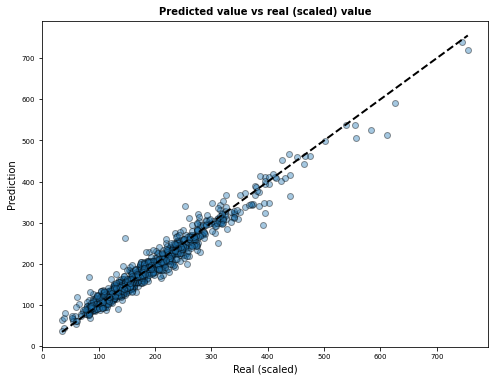

In [147]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain_scaled

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain_scaled, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain_scaled.min(), y_retrain_scaled.max()], [y_retrain_scaled.min(), y_retrain_scaled.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)